### import necessary libraries
### Reading the CSV file and displaying its contents

“First, we import libraries to handle data.
Then we read the CSV file using pandas and store it as a DataFrame.
Finally, we display the first few rows to understand the structure of the data.”

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Yt = pd.read_csv(r"C:\Users\VICKY\Desktop\Guvi\projects\project 3\youtube_ad_revenue_dataset.csv")

%matplotlib inline

In [2]:
Yt.head() 

,video_id,date,views,likes,comments,watch_time_minutes,video_length_minutes,subscribers,category,device,country,ad_revenue_usd
0,vid_3092,2024-09-24 10:50:40.993199,9936,1221.0,320.0,26497.214184,2.862137,228086,Entertainment,TV,IN,203.178237
1,vid_3459,2024-09-22 10:50:40.993199,10017,642.0,346.0,15209.747445,23.738069,736015,Gaming,Tablet,CA,140.880508
2,vid_4784,2024-11-21 10:50:40.993199,10097,1979.0,187.0,57332.658498,26.200634,240534,Education,TV,CA,360.134008
3,vid_4078,2025-01-28 10:50:40.993199,10034,1191.0,242.0,31334.517771,11.770340,434482,Entertainment,Mobile,UK,224.638261
4,vid_3522,2025-04-28 10:50:40.993199,9889,1858.0,477.0,15665.666434,6.635854,42030,Education,Mobile,CA,165.514388


In [3]:
Yt.shape

(122400, 12)

In [4]:
Yt.columns

Index(['video_id', 'date', 'views', 'likes', 'comments', 'watch_time_minutes',
       'video_length_minutes', 'subscribers', 'category', 'device', 'country',
       'ad_revenue_usd'],
      dtype='object')

In [5]:
Yt.dtypes

video_id                 object
date                     object
views                     int64
likes                   float64
comments                float64
watch_time_minutes      float64
video_length_minutes    float64
subscribers               int64
category                 object
device                   object
country                  object
ad_revenue_usd          float64
dtype: object

### checking for duplicates
“First, I checked for duplicate records in the dataset.
Duplicates can repeat the same information and affect model performance,
so I removed them to keep the data clean and unique.”

In [6]:
Yt.duplicated().sum()

np.int64(2400)

In [7]:
Yt.drop_duplicates(inplace=True)

### checking for null values
“After removing duplicates, I checked for null values in each column
to understand how much data was missing and where preprocessing was required.”

In [8]:
Yt.isnull().sum()

video_id                   0
date                       0
views                      0
likes                   6000
comments                6000
watch_time_minutes      6000
video_length_minutes       0
subscribers                0
category                   0
device                     0
country                    0
ad_revenue_usd             0
dtype: int64

### Preprocessing  

In [9]:
Yt['likes'] = Yt['likes'].fillna(0)
Yt['comments'] = Yt['comments'].fillna(0)


### “To handle abnormal or extreme values, I used the Z-score method.
 Z-score measures how far a data point is from the mean in terms of standard deviation.
 If the Z-score is greater than 3 or less than -3, it is treated as an outlier.”

In [10]:
from scipy import stats
num_Yt = Yt.select_dtypes(include=np.number)

#  Z-Score Method

threshold = 3

z_scores = np.abs(stats.zscore(num_Yt)) 


print("Size before check outliers:", Yt.shape)

outlier_rows = (z_scores > threshold).any(axis=1)

Yt_clean = Yt[~outlier_rows]

outlier_rows_Yt = Yt[outlier_rows]

print("Size after removing check outliers:", Yt_clean.shape)


Size before check outliers: (120000, 12)
Size after removing check outliers: (119684, 12)


### “After identifying outliers using Z-score,
I filled the missing values using the median of the column.
Median is preferred because it is not affected by extreme values
and gives a more stable representation of the data.”

In [11]:
Yt['watch_time_minutes'] = Yt['watch_time_minutes'].fillna(Yt['watch_time_minutes'].median())

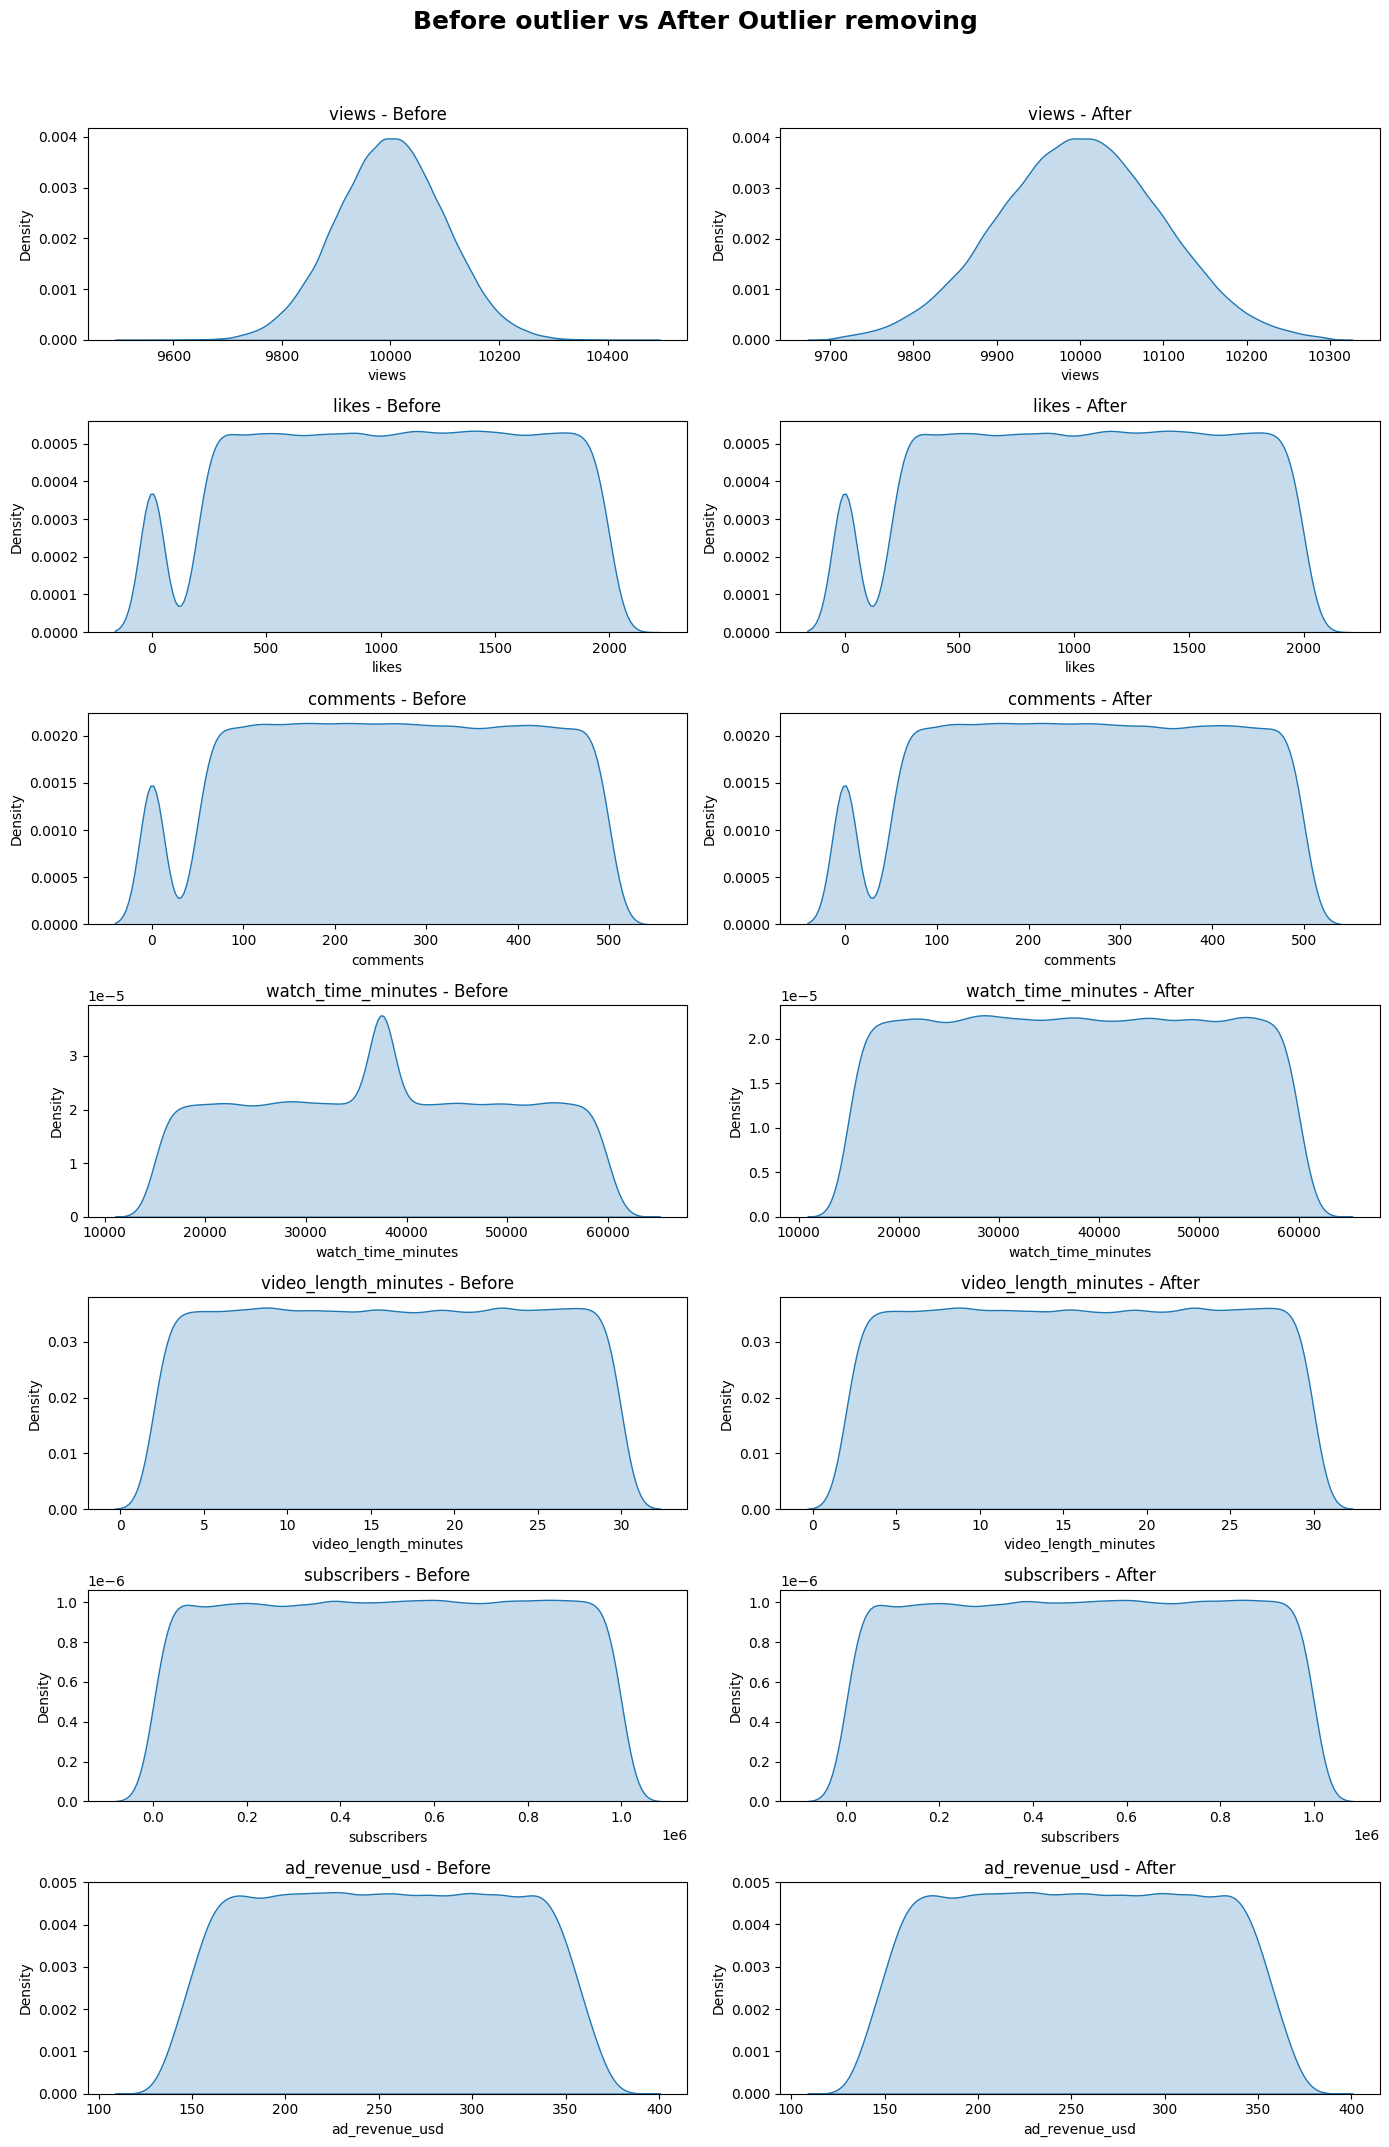

In [12]:
numeric_features = Yt.select_dtypes(include='number').columns

rows = len(numeric_features)

fig, axes = plt.subplots(rows, 2, figsize=(14, 3*rows))

fig.suptitle("Before outlier vs After Outlier removing",fontsize=18,fontweight="bold",y=1.02)

for i, col in enumerate(numeric_features):

    #  Before
    sns.kdeplot(x=Yt[col], ax=axes[i, 0], fill=True)
    axes[i, 0].set_title(f"{col} - Before")
    axes[i, 0].set_xlabel(col)

    #  After
    sns.kdeplot(x=Yt_clean[col], ax=axes[i, 1], fill=True)
    axes[i, 1].set_title(f"{col} - After")
    axes[i, 1].set_xlabel(col)

plt.tight_layout()
plt.show()

### “The before-and-after density plots clearly show that outlier removal reduces skewness and noise,
### resulting in cleaner, more stable data that improves regression model performance.” 

In [13]:
Yt.isnull().sum()


video_id                0
date                    0
views                   0
likes                   0
comments                0
watch_time_minutes      0
video_length_minutes    0
subscribers             0
category                0
device                  0
country                 0
ad_revenue_usd          0
dtype: int64

In [14]:
numeric_features = [feature for feature in Yt.columns if Yt[feature].dtype != 'O']
categorical_features = [feature for feature in Yt.columns if Yt[feature].dtype == 'O']

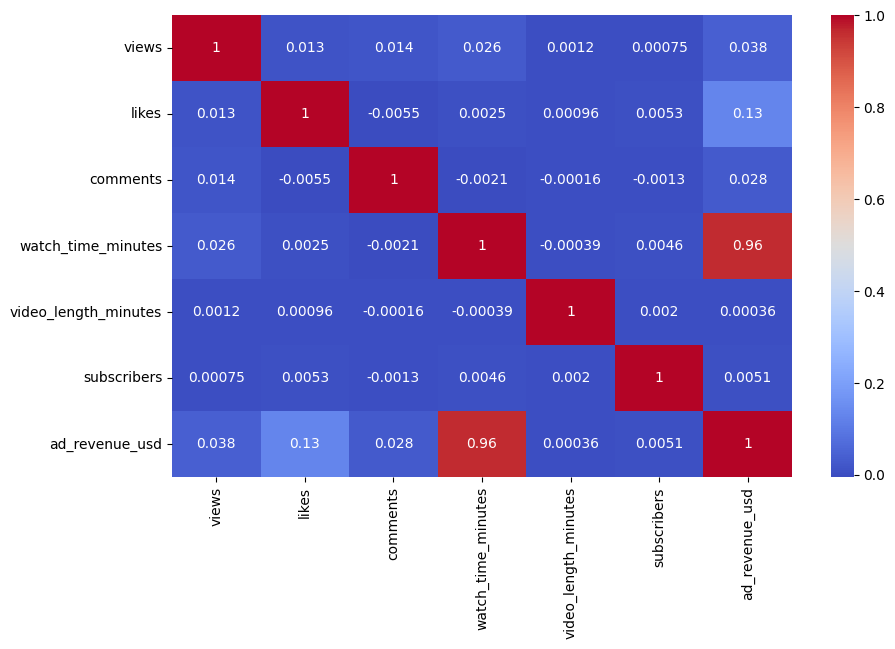

In [15]:

numeric_cols = Yt.select_dtypes(include=['int64','float64'])

plt.figure(figsize=(10,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.show()

## 🔍 Correlation Insight

The correlation heatmap shows that **watch time** has a very strong positive relationship with **ad revenue**,  
making it the most important predictor.

Other engagement metrics like **likes** and **views** show weak correlation, indicating that revenue is driven  
more by **viewer retention** than raw engagement.

In [16]:
Yt['total_engagement'] = Yt['likes'] + Yt['comments']
Yt['engagement_rate'] = Yt['total_engagement'] / (Yt['views'] + 1)


### Engagement Feature Engineering

Total engagement was created by combining likes and comments to represent overall audience interaction.  
An engagement rate was then calculated by normalizing total engagement by views, allowing fair comparison across videos with different view counts.

In [17]:
Yt.columns

Index(['video_id', 'date', 'views', 'likes', 'comments', 'watch_time_minutes',
       'video_length_minutes', 'subscribers', 'category', 'device', 'country',
       'ad_revenue_usd', 'total_engagement', 'engagement_rate'],
      dtype='object')

In [18]:
Yt['date'] = pd.to_datetime(Yt['date'])

Yt['year'] = Yt['date'].dt.year
Yt['month'] = Yt['date'].dt.month
Yt['Quarter'] = Yt['date'].dt.quarter


In [19]:
Yt.to_csv("C:\\Users\\VICKY\\Desktop\\Guvi\\projects\\project 3\\Cleaned_Yt.csv", index=False)

## Skewness of the Dependent Variable

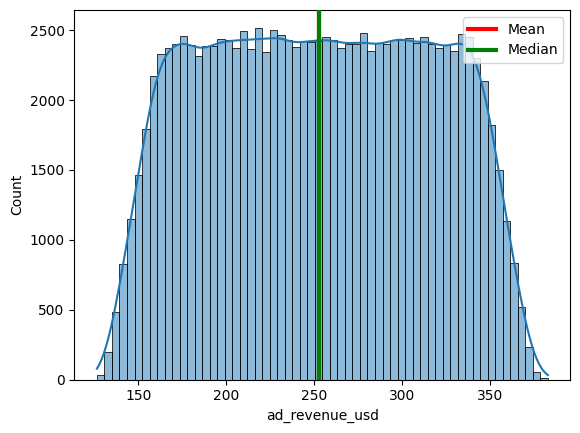

Skewness Value: 0.0009478946949712725
Skewness: 0.00 ( Normal Distribution)


In [20]:
skew_value = Yt['ad_revenue_usd'].skew()

# 1. Plot Graph (lw=3 and zorder=5 ensures lines are visible)
sns.histplot(Yt['ad_revenue_usd'], kde=True)
plt.axvline(Yt['ad_revenue_usd'].mean(), color='r', lw=3, label='Mean', zorder=5)
plt.axvline(Yt['ad_revenue_usd'].median(), color='g', lw=3, label='Median', zorder=5)
plt.legend(); plt.show()


# Print the value
print(f"Skewness Value: {skew_value}")

res = ("Positive" if skew_value > 0.5 else "Negative" if skew_value < -0.5 else " Normal Distribution")

print(f"Skewness: {skew_value:.2f} ({res})")

### Skewness
 “I checked the skewness of the dependent variable to verify normality.
Since the skewness value is close to zero and the distribution appears symmetric,
it confirms that the target variable follows a normal distribution,
making it suitable for regression modeling.”

In [21]:
Yt = pd.get_dummies(
    Yt,
    columns=['category', 'device', 'country'],
    drop_first=True
)

In [22]:
Yt.dtypes

video_id                          object
date                      datetime64[ns]
views                              int64
likes                            float64
comments                         float64
watch_time_minutes               float64
video_length_minutes             float64
subscribers                        int64
ad_revenue_usd                   float64
total_engagement                 float64
engagement_rate                  float64
year                               int32
month                              int32
Quarter                            int32
category_Entertainment              bool
category_Gaming                     bool
category_Lifestyle                  bool
category_Music                      bool
category_Tech                       bool
device_Mobile                       bool
device_TV                           bool
device_Tablet                       bool
country_CA                          bool
country_DE                          bool
country_IN      

## Sklearn model to split the data into train and test sets

In [23]:
from sklearn.model_selection import train_test_split

X = Yt.drop(columns=['ad_revenue_usd', 'month','year','engagement_rate','video_id','date','Quarter'], axis=1)
y = Yt['ad_revenue_usd']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

“Scaling is important to ensure all features contribute equally to the model.
It improves convergence speed, model stability, and accuracy,
especially for distance-based and regression models.”

In [24]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [25]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape        

((96000, 20), (24000, 20), (96000,), (24000,))

In [26]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(X_train, y_train)




,"fit_intercept fit_intercept: bool, default=TrueWhether to calculate the intercept for this model. If setto False, no intercept will be used in calculations(i.e. data is expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"tol tol: float, default=1e-6The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for the `lsqr` solver.`tol` is set as `atol` and `btol` of :func:`scipy.sparse.linalg.lsqr` whenfitting on sparse training data. This parameter has no effect when fittingon dense data... versionadded:: 1.7",1e-06
,"n_jobs n_jobs: int, default=NoneThe number of jobs to use for the computation. This will only providespeedup in case of sufficiently large problems, that is if firstly`n_targets > 1` and secondly `X` is sparse or if `positive` is setto `True`. ``None`` means 1 unless in a:obj:`joblib.parallel_backend` context. ``-1`` means using allprocessors. See :term:`Glossary ` for more details.",None
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive. Thisoption is only supported for dense arrays.For a comparison between a linear regression model with positive constraintson the regression coefficients and a linear regression without such constraints,see :ref:`sphx_glr_auto_examples_linear_model_plot_nnls.py`... versionadded:: 0.24",False


In [27]:
y_pred = model.predict(X_test)


In [28]:
print('Coefficients: \n', model.coef_)

Coefficients: 
 [ 7.00036334e-03  4.72129722e-03  4.51751041e-03  4.71470026e-03
  3.33300469e-03  7.75299203e-08  9.23880763e-03  5.91995850e-03
 -2.23116740e-02  1.86400427e-02 -8.18823466e-02  6.89511182e-02
 -1.02490358e-02 -1.70415401e-01 -6.24061264e-02 -5.44849699e-02
 -1.38131144e-01  1.76265817e-02 -7.37595414e-02 -1.72877828e-01]


## We can check error metrics Like MAE, MSE, RMSE
## and performance metrics like R2 Score all the models and we can choose the best model based on R2 Score and least error metrics values.

In [29]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error,mean_absolute_percentage_error

r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mape = mean_absolute_percentage_error(y_test, y_pred)

print("R2:", r2)
print("MAE:", mae)
print("RMSE:", rmse)
print("MAPE:", mape)

R2: 0.9487164005995864
MAE: 4.7879186307578205
RMSE: 14.017554750716991
MAPE: 0.020566752420858824


In [30]:
model.score(X_train, y_train)
model.score(X_test, y_test)


0.9487164005995864

# Let us try another model - Ridge Regression

In [31]:
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1.0)
ridge.fit(X_train_scaled, y_train)






,"alpha alpha: {float, ndarray of shape (n_targets,)}, default=1.0Constant that multiplies the L2 term, controlling regularizationstrength. `alpha` must be a non-negative float i.e. in `[0, inf)`.When `alpha = 0`, the objective is equivalent to ordinary leastsquares, solved by the :class:`LinearRegression` object. For numericalreasons, using `alpha = 0` with the `Ridge` object is not advised.Instead, you should use the :class:`LinearRegression` object.If an array is passed, penalties are assumed to be specific to thetargets. Hence they must correspond in number.",1.0
,"fit_intercept fit_intercept: bool, default=TrueWhether to fit the intercept for this model. If setto false, no intercept will be used in calculations(i.e. ``X`` and ``y`` are expected to be centered).",True
,"copy_X copy_X: bool, default=TrueIf True, X will be copied; else, it may be overwritten.",True
,"max_iter max_iter: int, default=NoneMaximum number of iterations for conjugate gradient solver.For 'sparse_cg' and 'lsqr' solvers, the default value is determinedby scipy.sparse.linalg. For 'sag' solver, the default value is 1000.For 'lbfgs' solver, the default value is 15000.",None
,"tol tol: float, default=1e-4The precision of the solution (`coef_`) is determined by `tol` whichspecifies a different convergence criterion for each solver:- 'svd': `tol` has no impact.- 'cholesky': `tol` has no impact.- 'sparse_cg': norm of residuals smaller than `tol`.- 'lsqr': `tol` is set as atol and btol of scipy.sparse.linalg.lsqr, which control the norm of the residual vector in terms of the norms of matrix and coefficients.- 'sag' and 'saga': relative change of coef smaller than `tol`.- 'lbfgs': maximum of the absolute (projected) gradient=max|residuals| smaller than `tol`... versionchanged:: 1.2 Default value changed from 1e-3 to 1e-4 for consistency with other linear models.",0.0001
,"solver solver: {'auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'}, default='auto'Solver to use in the computational routines:- 'auto' chooses the solver automatically based on the type of data.- 'svd' uses a Singular Value Decomposition of X to compute the Ridge coefficients. It is the most stable solver, in particular more stable for singular matrices than 'cholesky' at the cost of being slower.- 'cholesky' uses the standard :func:`scipy.linalg.solve` function to obtain a closed-form solution.- 'sparse_cg' uses the conjugate gradient solver as found in :func:`scipy.sparse.linalg.cg`. As an iterative algorithm, this solver is more appropriate than 'cholesky' for large-scale data (possibility to set `tol` and `max_iter`).- 'lsqr' uses the dedicated regularized least-squares routine :func:`scipy.sparse.linalg.lsqr`. It is the fastest and uses an iterative procedure.- 'sag' uses a Stochastic Average Gradient descent, and 'saga' uses its improved, unbiased version named SAGA. Both methods also use an iterative procedure, and are often faster than other solvers when both n_samples and n_features are large. Note that 'sag' and 'saga' fast convergence is only guaranteed on features with approximately the same scale. You can preprocess the data with a scaler from :mod:`sklearn.preprocessing`.- 'lbfgs' uses L-BFGS-B algorithm implemented in :func:`scipy.optimize.minimize`. It can be used only when `positive` is True.All solvers except 'svd' support both dense and sparse data. However, only'lsqr', 'sag', 'sparse_cg', and 'lbfgs' support sparse input when`fit_intercept` is True... versionadded:: 0.17 Stochastic Average Gradient descent solver... versionadded:: 0.19 SAGA solver.",'auto'
,"positive positive: bool, default=FalseWhen set to ``True``, forces the coefficients to be positive.Only 'lbfgs' solver is supported in this case.",False
,"random_state random_state: int, RandomState instance, default=NoneUsed when ``solver`` == 'sag' or 'saga' to shuffle the data.See :term:`Glossary ` for details... versionadded:: 0.17 `random_state` to support Stochastic Average Gradient.",None


In [32]:
y_pred_ridge = ridge.predict(X_test_scaled)

In [33]:
r2_ridge = r2_score(y_test, y_pred_ridge)
mae_ridge = mean_absolute_error(y_test, y_pred_ridge)
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
mape_ridge = mean_absolute_percentage_error(y_test, y_pred_ridge)

print("Ridge Regression Performance")
print("R2:", r2_ridge)
print("MAE:", mae_ridge)
print("RMSE:", rmse_ridge)
print("MAPE:", mape_ridge)

Ridge Regression Performance
R2: 0.9487163827229882
MAE: 4.787943442442313
RMSE: 14.017557193858412
MAPE: 0.020567039505585378


### "Ridge regression adds L2 regularization to penalize large coefficients, which helps reduce overfitting while retaining all features.”

In [34]:
from sklearn.linear_model import Lasso

lasso = Lasso(alpha=0.01)
lasso.fit(X_train_scaled, y_train)

y_pred_lasso = lasso.predict(X_test_scaled)

r2_lasso = r2_score(y_test, y_pred_lasso)
mae_lasso = mean_absolute_error(y_test, y_pred_lasso)
rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
mape_lasso = mean_absolute_percentage_error(y_test, y_pred_lasso)

print("Lasso Regression Performance")
print("R2:", r2_lasso)
print("MAE:", mae_lasso)
print("RMSE:", rmse_lasso)
print("MAPE:", mape_lasso)


Lasso Regression Performance
R2: 0.9487215841397979
MAE: 4.790426983074299
RMSE: 14.016846313753534
MAPE: 0.020580688715509655


### “🏁Linear, Ridge, and Lasso produced similar results because the dataset has strong predictive features and low multicollinearity. 
Regularization did not significantly change coefficients, indicating that the baseline linear model is already well-generalized🚨.”

## 😎Let us try Random Forest and gradient boosting models to see if we can improve performance.

In [35]:
from sklearn.ensemble import RandomForestRegressor


rf = RandomForestRegressor(
    n_estimators=200,
    random_state=42,
    max_depth=None
)

rf.fit(X_train_scaled, y_train)

y_pred_rf = rf.predict(X_test_scaled)

r2_rf = r2_score(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
mape_rf =mean_absolute_percentage_error(y_test, y_pred_rf)

print("Random Forest Performance")
print("R2:", r2_rf)
print("MAE:", mae_rf)
print("RMSE:", rmse_rf)
print("MAPE:", mape_rf)


Random Forest Performance
R2: 0.949936898540804
MAE: 3.486941345690637
RMSE: 13.849748501334961
MAPE: 0.014961245879418623


In [36]:
from sklearn.ensemble import GradientBoostingRegressor

gbr = GradientBoostingRegressor(
    n_estimators=200,
    learning_rate=0.05,
    max_depth=3,
    random_state=42
)

gbr.fit(X_train, y_train)

y_pred_gbr = gbr.predict(X_test)

r2_gbr = r2_score(y_test, y_pred_gbr)
mae_gbr = mean_absolute_error(y_test, y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(y_test, y_pred_gbr))
mape_gpr = mean_absolute_percentage_error(y_test, y_pred_gbr)

print("Gradient Boosting Performance")
print("R2:", r2_gbr)
print("MAE:", mae_gbr)
print("RMSE:", rmse_gbr)
print("MAPE:", mape_gpr)


Gradient Boosting Performance
R2: 0.9522975779278341
MAE: 3.548718084001197
RMSE: 13.519269541483931
MAPE: 0.015303787059759136


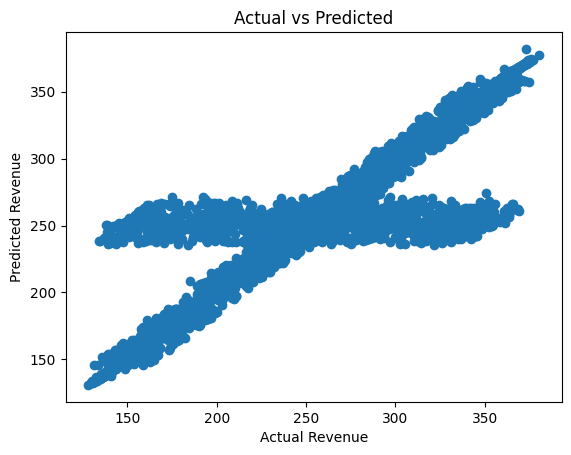

In [37]:
plt.scatter(y_test, y_pred_gbr)
plt.xlabel("Actual Revenue")
plt.ylabel("Predicted Revenue")
plt.title("Actual vs Predicted")
plt.show()


In [38]:


results = pd.DataFrame({
    'Model': [
        'Linear Regression',
        'Ridge Regression',
        'Lasso Regression',
        'Random Forest',
        'Gradient Boosting'
    ],
    'R2': [
        r2,
        r2_ridge,
        r2_lasso,
        r2_rf,
        r2_gbr
    ],
    'MAE': [
        mae,
        mae_ridge,
        mae_lasso,
        mae_rf,
        mae_gbr
    ],
    'RMSE': [
        rmse,
        rmse_ridge,
        rmse_lasso,
        rmse_rf,
        rmse_gbr
    ]
    ,'MAPE': [
        mape,
        mape_ridge,
        mape_lasso,
        mape_rf,
        mape_gpr
    ]
})

results


,Model,R2,MAE,RMSE,MAPE
0,Linear Regression,0.948716,4.787919,14.017555,0.020567
1,Ridge Regression,0.948716,4.787943,14.017557,0.020567
2,Lasso Regression,0.948722,4.790427,14.016846,0.020581
3,Random Forest,0.949937,3.486941,13.849749,0.014961
4,Gradient Boosting,0.952298,3.548718,13.519270,0.015304


## "Random Forest Regression was selected as the final model because it achieved the highest accuracy, lowest prediction error, and effectively captured non-linear patterns in viewer behavior and revenue generation."

In [39]:
import joblib
joblib.dump(gbr, "Gradient Boosting Regressor.pkl")



['Gradient Boosting Regressor.pkl']

## “The saved model is loaded using joblib for inference on new unseen data.”

In [40]:

model = joblib.load("Gradient Boosting Regressor.pkl")



In [41]:
feature_columns = X.columns


In [42]:

joblib.dump(feature_columns, "model_features.pkl")


['model_features.pkl']

In [43]:
input_data = pd.DataFrame({
    'views': [12000],
    'likes': [800],
    'comments': [120],
    'watch_time_minutes': [320000],
    'video_length_minutes': [100],
    'subscribers': [500000],

    # category
    'category_Entertainment': [1],
    'category_Gaming': [0],
    'category_Lifestyle': [0],
    'category_Music': [0],
    'category_Tech': [0],

    # device
    'device_Mobile': [1],
    'device_TV': [0],
    'device_Tablet': [0],

    # country
    'country_US': [1],
    'country_IN': [0],
    'country_UK': [0],
    'country_CA': [0],
    'country_DE': [0]
})


In [44]:
model_features = joblib.load("model_features.pkl")

input_data = input_data.reindex(columns=model_features, fill_value=0)



In [45]:
predicted_revenue = model.predict(input_data)
print("Predicted Ad Revenue:", predicted_revenue[0])


Predicted Ad Revenue: 348.1394538659693


In [46]:
print(type(model))


<class 'sklearn.ensemble._gb.GradientBoostingRegressor'>
